![title](Pic_1.png)

In [1]:
# written by: Maximilian Baust & Ruediger Goebl
#               Chair for Computer Aided Medical Procedures
#               & Augmented Reality
#               Technische Universität München
#               11-19-2018
#
########################################

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def weight(w,sigma):
    w = np.exp(-(w/sigma)**2)
    # w = 1./( 1 + (w/sigma)**4 )
    # w = 1
    return w

![title](Pic_2.png)

In [2]:
def assemble(numbering, I, sigma):
    num_unknowns = int(round(np.max(numbering)))+1
    b = np.zeros(num_unknowns)
    A = np.zeros([num_unknowns, num_unknowns])

    for i in range(1, I.shape[0] - 1):
        for j in range(1, I.shape[1] - 1):
            if numbering[i, j] + 1 > 0:

                W = 0

                # generate entries for northern neighbor
                # compute weight
                w = weight(I[i, j] - I[i - 1, j], sigma)

                # update sum
                W = W + w

                # check, if there is a northern neighbor
                # with unknown potential value
                if numbering[i - 1, j] >= 0:
                    # generate entry
                    A[numbering[i, j], numbering[i - 1, j]] = -w

                # check, if there is a northern neighbor
                # with known potential value 1
                if numbering[i - 1, j] == -2:
                    # modify right hand side
                    b[numbering[i, j]] = b[numbering[i, j]] + w

                """To be completed!!!"""
                # check for southern neighbor
                w = weight(I[i, j] - I[i + 1, j], sigma)
                W = W + w
                if numbering[i + 1, j] >= 0:
                    A[numbering[i, j], numbering[i + 1, j]] = -w
                if numbering[i + 1, j] == -2:
                    b[numbering[i, j]] = b[numbering[i, j]] + w
                    
                # check for western neighbor    
                w = weight(I[i, j] - I[i, j - 1], sigma)
                W = W + w
                if numbering[i, j - 1] >= 0:
                    A[numbering[i, j], numbering[i, j - 1]] = -w
                if numbering[i, j - 1] == -2:
                    b[numbering[i, j]] = b[numbering[i, j]] + w
                    
                # check for eastern neighbor    
                w = weight(I[i, j] - I[i, j + 1], sigma)
                W = W + w
                if numbering[i, j + 1] >= 0:
                    A[numbering[i, j], numbering[i, j + 1]] = -w
                if numbering[i, j + 1] == -2:
                    b[numbering[i, j]] = b[numbering[i, j]] + w

                # finally, generate entry for the center pixel
                A[numbering[i, j], numbering[i, j]] = W

    return A, b

In [3]:
# choose sigma
sigma = 0.05
use_small_images = False

# load image
if use_small_images:
    I = np.array(Image.open("mri_small.png"))/255
else:
    I = np.array(Image.open("mri.png")) / 255

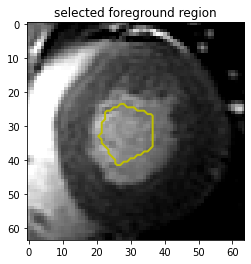

In [4]:
# show image and select foreground
plt.figure()
plt.imshow(I, cmap="gray")
plt.title('selected foreground region')
# This could in the real world be determined by user
if use_small_images:
    R = np.array(Image.open("R_small.png"))
else:
    R = np.array(Image.open("R.png"))
R = R / np.max(R)
R = R.astype(int)
plt.contour(R, levels=[0.5], colors=['y'], linewidths=[2])
plt.draw()


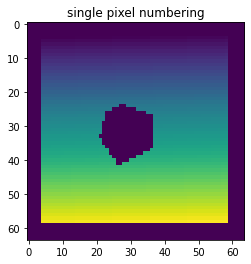

In [5]:
# generate mask where pixel values shall be computed
mask = np.zeros(I.shape, dtype=np.int)
mask[4:-5,4:-5] = 1
mask[R == 1] = 0

# generate numbering

# we use -1 to mark pixels with known potential 0 volts
numbering = - np.ones(I.shape, dtype=np.int)
num_unknown_pixels = np.sum(mask)
numbering[mask == 1] = np.asarray(range(0, num_unknown_pixels))

# we use -2 to mark pixels with known potential 1 volts
numbering[R == 1] = -2
plt.figure()
plt.imshow(numbering)
plt.title('single pixel numbering')
plt.draw()

![title](Pic_3.png)

In [6]:
# assemble random walker equation system
[A, b] = assemble(numbering, I, sigma)

# compute solution
x = np.linalg.solve(A, b)

In [7]:
# generate segmentation
seg = np.zeros(I.shape)
seg[R == 1] = 1
seg[numbering >= 0] = x


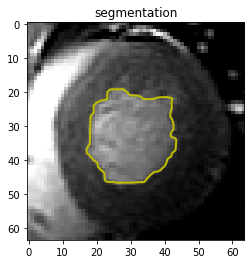

In [8]:
# visualize segmentation
plt.figure()
plt.imshow(I, cmap="gray")
plt.contour(seg, levels=[0.5], colors=['y'], linewidths=[2])
plt.title('segmentation')
plt.draw()